In [58]:
import pandas as pd
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.metrics import roc_curve,auc
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import time
from IPython.display import Image

# Data loading

Data are csv file, produced by running over data without $D^{0}$ particles, and over data with $D^{0}$ particles. 
These data are already the results of algorithm that performed track association (pairs) in order to reconstruct the
invariant mass. The output of these algorithms are binary file (ROOT format) ; therefore I needed to (re)save the output into .csv files.

## Features
Features are : mass, signK, signPi, dcaDaughters, pointingAngle, dcaK, dcaPi, cosThetaStar, ptK, ptPi, decayLength, class
### Explanations :
<ul>
<li> mass : invariant mass of the pair association of a Kaon track with a Pion track
<li> signK(Pi) : sign (positive or negative) of the track
<li> dcaDaughters : distance of closest approach between the 2 tracks
<li> pointingAngle : angle (radians) between the $D^{0}$ momentum and the vector joining the primary and secondary vertex
<li> dcaK(Pi): distance of closest approach of the Kaon(Pion) track to the primary vertex
<li> cosThetaStar : angle (radians) in the rest frame between the 2 daughters
<li> PtK(Pi) : transverse momentum (Px,Py) of the Kaon(Pion) track
<li> decayLength : distance (cm) between the primary and secondary vertex
<li> class : 0 = background, 1 = signal
</ul>

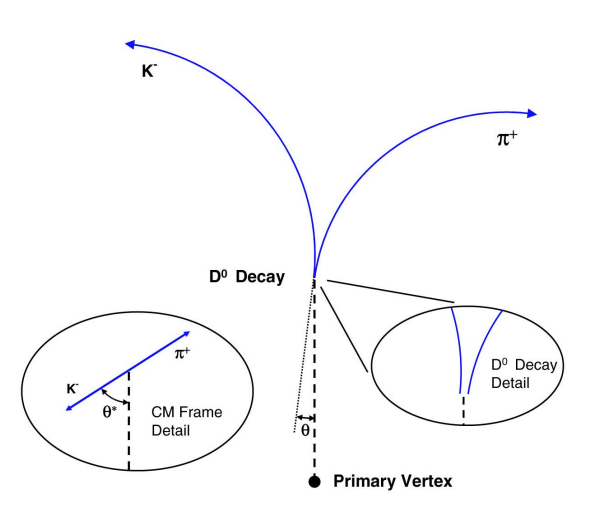

In [23]:
Image(filename='/Users/jonathanbouchet/Desktop/WORK/STAR/SSD/TRACKING/D0_MachineLearning/D0_decay.png')

In [24]:
dataBackground = pd.read_csv("/Users/jonathanbouchet/Desktop/WORK/STAR/SSD/TRACKING/D0_MachineLearning/background.csv",sep=',')

In [25]:
dataSignal = pd.read_csv("/Users/jonathanbouchet/Desktop/WORK/STAR/SSD/TRACKING/D0_MachineLearning/prepareSignal/signal.csv",sep=',')

In [26]:
dataBackground.head()

,mass,signK,signPi,dcaDaughters,pointingAngle,dcaK,dcaPi,cosThetaStar,ptK,ptPi,decayLength,class
0,1.63735,-1,-1,0.002518,0.194654,0.005897,0.006270,0.291135,0.792444,1.297860,0.008942,0
1,1.86441,-1,-1,0.001281,0.265010,0.006556,0.005099,-0.613580,1.316910,0.696700,0.009133,0
2,1.73987,-1,-1,0.001281,0.265010,0.005099,0.006556,0.515589,0.696700,1.316910,0.009133,0
3,1.67234,-1,-1,0.001180,0.201383,0.006214,0.006006,-0.327630,0.781476,0.691193,0.007627,0
4,1.63167,-1,-1,0.001180,0.201383,0.006006,0.006214,0.228135,0.691193,0.781476,0.007627,0


In [27]:
dataSignal.head()

,mass,signK,signPi,dcaDaughters,pointingAngle,dcaK,dcaPi,cosThetaStar,ptK,ptPi,decayLength,class
0,1.85510,-1,1,0.001900,0.635031,0.012480,0.002983,-0.011599,0.922638,0.867883,0.012573,1
1,1.86001,1,-1,0.001900,0.635031,0.002983,0.012480,-0.079300,0.867883,0.922638,0.012573,1
2,1.84737,1,-1,0.006280,0.235240,0.014969,0.019484,0.138953,0.728954,0.999042,0.019195,1
3,1.86336,-1,1,0.006280,0.235240,0.019484,0.014969,-0.197181,0.999042,0.728954,0.019195,1
4,1.87941,-1,1,0.002212,0.218987,0.007178,0.016127,0.606180,0.629917,1.334020,0.015851,1


In [28]:
print 'background sample size :',dataBackground.shape
print 'signal sample size :',dataSignal.shape

background sample size : (110375, 12)
signal sample size : (6344, 12)


Comments : the difference in size between the 2 samples comes from the fact that the signal sample is the result of simulation, which took more time and CPU ressources to produce

The next step is to concatenate these 2 dataframes, and then generate X and y samples for training where X will be a dataframe containing the features and y the array containing the class.

In [35]:
result = dataBackground.append(dataSignal, ignore_index=True)
result.shape

(116719, 12)

In [36]:
result.head()

,mass,signK,signPi,dcaDaughters,pointingAngle,dcaK,dcaPi,cosThetaStar,ptK,ptPi,decayLength,class
0,1.63735,-1,-1,0.002518,0.194654,0.005897,0.006270,0.291135,0.792444,1.297860,0.008942,0
1,1.86441,-1,-1,0.001281,0.265010,0.006556,0.005099,-0.613580,1.316910,0.696700,0.009133,0
2,1.73987,-1,-1,0.001281,0.265010,0.005099,0.006556,0.515589,0.696700,1.316910,0.009133,0
3,1.67234,-1,-1,0.001180,0.201383,0.006214,0.006006,-0.327630,0.781476,0.691193,0.007627,0
4,1.63167,-1,-1,0.001180,0.201383,0.006006,0.006214,0.228135,0.691193,0.781476,0.007627,0


In [37]:
result.tail()

,mass,signK,signPi,dcaDaughters,pointingAngle,dcaK,dcaPi,cosThetaStar,ptK,ptPi,decayLength,class
116714,1.85215,1,-1,0.002440,0.295796,0.007992,0.008680,0.442690,0.945062,1.419160,0.014569,1
116715,1.87404,1,-1,0.002168,1.218270,0.005598,0.003606,0.687421,0.594602,1.282300,0.005068,1
116716,1.82748,-1,1,0.009599,0.121128,0.021656,0.034141,0.230659,0.571412,1.138160,0.034743,1
116717,1.86040,1,-1,0.009599,0.121128,0.034141,0.021656,-0.303338,1.138160,0.571412,0.034743,1
116718,1.86472,1,-1,0.014990,1.023950,0.019963,0.009155,0.589404,0.680472,1.055390,0.017018,1


In [85]:
features = ["dcaDaughters","pointingAngle","dcaK","dcaPi","cosThetaStar","ptK","ptPi","decayLength"]
classResult = ['class']

In [86]:
X = result[features]
y= result[classResult]
y=np.ravel(y)
# we split the X, y samples into training/testing samples
# the idea is to train a classifier on the training sample, then to evaluate its accuracy on the testing sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [87]:
y.shape

(116719,)

#### 1st test with KNN classifier

In [88]:
# next we define the Knn classifier, not optimization here
knn = KNeighborsClassifier()
print knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [89]:
# fit the model with data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [90]:
# store the predicted response values
y_pred = knn.predict(X_test)
# compute classification accuracy for the logistic regression model
print metrics.accuracy_score(y_test, y_pred)

0.979223783413


#### 2nd test with RandomForest

In [91]:
start_time = time.time()
rfc = RandomForestClassifier()
print rfc
rfc.fit(X_train, y_train)
print "Total time took %f seconds" % (time.time()-start_time)
y_pred = rfc.predict(X_test)
print metrics.accuracy_score(y_test, y_pred)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Total time took 2.300429 seconds
0.989783241947


Next we plot the ROC curves

In [92]:
prediction_knn = knn.predict_proba(X_test)
y_pred_knn = prediction_knn[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn,tpr_knn)

In [93]:
prediction_rfc = rfc.predict_proba(X_test)
y_pred_rfc = prediction_rfc[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, y_pred_rfc)
roc_auc_rfc = auc(fpr_rfc,tpr_rfc)

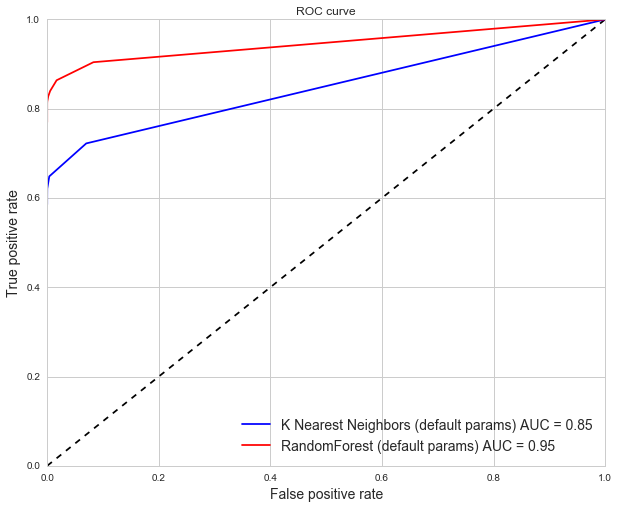

In [95]:
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, 'b',label = 'K Nearest Neighbors (default params) AUC = %0.2f' % roc_auc_knn)
plt.plot(fpr_rfc, tpr_rfc, 'r',label = 'RandomForest (default params) AUC = %0.2f' % roc_auc_rfc)
plt.xlabel('False positive rate',fontsize=14)
plt.ylabel('True positive rate',fontsize=14)
plt.title('ROC curve')
plt.legend(loc='best',prop={'size':14})
plt.show()